In [28]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as pl

import mesa_reader as ms
import glob
import pickle

import astropy.units as u
from astropy.units import cds
from astropy.io import ascii
from astropy.table import Table
import numpy.ma as ma

def Kepler_period(orbital_radius, stellar_mass):
    return np.sqrt(orbital_radius**3/stellar_mass)

pickle_file = 'stellar_radii.pickle'

#min Ms allowed
min_Ms = 0.2

In [14]:
def Rappaport_Roche_limit(Mp=None, Rp=None, rhop=None, incompressible=False):
    #Returns Roche limit period for given density
    #  based on Rappaport+ (2013) ApJL 773, L15 -- 
    #  http://iopscience.iop.org/article/10.1088/2041-8205/773/1/L15/meta

    if(rhop is None):
        rhop = Mp/(4.*np.pi/3.*Rp**3.)

    #For a planet comprised of a highly compressible fluid
    period0 = 9.6/24.*u.day #days

    #A body comprised of an incompressible fluid with negligible bulk tensile strength
    if(incompressible):
        period0 = 12.6/24.*u.day #days
          
    return period0*np.sqrt(1.*u.g/u.cm**3/(rhop.to('g/cm^3')))

The following routine provides an interpolated $R_*$ from a grid of MESA stellar evolution files.

In [17]:
#First convert MESA results to python pickle file
# dir='history_files/'
# file_list = glob.glob(dir + "*.data")

# stellar_masses = np.arange(0.2, 2.1, 0.1)

# max_entries = 0
# #Ms = 0.1 doesn't have a long enough evolution
# for i in range(1, len(file_list)):
#     results = ms.history_data('.', slname=file_list[i], clean_starlog=False)
#     max_entries = max([max_entries, len(results.get('star_age'))])

# ages = np.empty([len(stellar_masses), max_entries])
# radii = np.empty([len(stellar_masses), max_entries])

# for i in range(len(file_list)-1):
#     results = ms.history_data('.', slname=file_list[i+1], clean_starlog=False)
#     temp = results.get('star_age') 
    
#     ages[i][0:len(temp)] = temp    
#     radii[i][0:len(temp)] = 10.**(results.get('log_R'))

# pickle.dump([stellar_masses, ages, radii], open(pickle_file, 'w'))

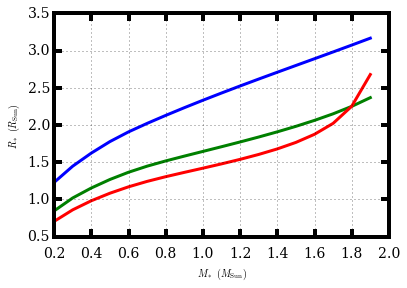

In [24]:
from scipy.interpolate import interp1d

def stellar_radius(stellar_mass, desired_age=3e6, dir='history_files/'):    #load in mesa history files  
    stellar_masses, ages, radii = pickle.load(open(pickle_file, 'rb'))
    
    tabulated_stellar_radii_at_age = np.empty(len(stellar_masses))
    for i in range(len(stellar_masses)):
        x = ages[i][:]
        y = radii[i][:]
        tabulated_stellar_radii = interp1d(x, y)
        tabulated_stellar_radii_at_age[i] = tabulated_stellar_radii(desired_age)

    stellar_radii = interp1d(stellar_masses, tabulated_stellar_radii_at_age)
    return stellar_radii(stellar_mass)
    
Ms = np.arange(0.2, 2., 0.1)
pl.plot(Ms, stellar_radius(Ms, desired_age=1e6))
pl.plot(Ms, stellar_radius(Ms, desired_age=3e6))
pl.plot(Ms, stellar_radius(Ms, desired_age=5e6))
pl.tick_params(which='both', labelsize=14)
pl.xlabel('$M_*\ (M_{\\rm Sun})$')
pl.ylabel('$R_*\ (R_{\\rm Sun})$')

In [20]:
# Rs = stellar_radius(1., desired_age=10.**np.linspace(6., 9.))
Rs = stellar_radius(1., desired_age=1e5)
print(Rs)

[[  1.00000000e-05   2.20000000e-05   3.64000000e-05 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.00000000e-05   2.20000000e-05   3.64000000e-05 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.00000000e-05   2.20000000e-05   3.64000000e-05 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  1.00000000e-05   2.20000000e-05   3.64000000e-05 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.00000000e-05   2.20000000e-05   3.64000000e-05 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.00000000e-05   2.20000000e-05   3.64000000e-05 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
5.19580433864


Most hot Jupiters are unstable against tidal decay of their orbits -- updated version of Fig. 1 from Levrard+ (2009 -- http://adsabs.harvard.edu/abs/2009ApJ...692L...9L)

In [21]:
#Assumes units are correct

def moment_of_inertia(M, R, k=0.06):
    #k = 0.06 from Levrard+ (2009) for Sun-like stars
    return k*M*R*R

def rot_rate(R, V):   
    return V/R

def rot_ang_mom(C, Omega):
    return C*Omega

def orb_ang_mom(Mp, Ms, a, e=0.):
    return (Ms*Mp)/np.sqrt(Ms + Mp)*np.sqrt(4.*np.pi**2*a*(1. - e**2.))
    
def Lcrit(Ms, Cs, Mp, Cp):
    #Eqn 1 from Levrard+ (2009)
    return 4.*((4.*np.pi**2)**2/27.*Ms**3*Mp**3/(Ms + Mp)*(Cs + Cp))**(1./4)

In [22]:
Rsun_to_AU = 0.00465113572
Rsun_to_km = 6.955e5
Mjup_to_Msun = 0.000954248366
Rjup_to_AU = 0.00046732617
days_to_s = 86400.
years_to_s = 3.15569e7

Omega_sun = 2.*np.pi/(30.*days_to_s)

#Read in data
#NAME,A,PER,ECC,MASS,R,MSTAR,RSTAR,VSINI
data_file_name = "exoplanets-org_alt0p1AU_2015Jul7.csv"
data = ascii.read(data_file_name, fill_values=[('', '1e38')])
print(np.min(data['A']))

data['Cs'] = moment_of_inertia(data['MSTAR'], data['RSTAR']*Rsun_to_AU)
data['Omegas'] = rot_rate(data['RSTAR']*Rsun_to_km, data['VSINI'])

#Assume solar rotation
#data['Omegas'] = data['Omegas'].filled(Omega_sun)

#k from http://nssdc.gsfc.nasa.gov/planetary/factsheet/jupiterfact.html
data['Cp'] = moment_of_inertia(data['MASS']*Mjup_to_Msun, data['R']*Rjup_to_AU, k=0.254)
data['Omegap'] = 2.*np.pi/(data['PER']*days_to_s)

data['Lorb'] = orb_ang_mom(data['MASS']*Mjup_to_Msun, data['MSTAR'], data['A'])
data['Lrots'] = rot_ang_mom(data['Cs'], data['Omegas']*years_to_s)
data['Lrotp'] = rot_ang_mom(data['Cp'], data['Omegap']*years_to_s)
#maximizing system angular momentum by assuming everything lines up
data['Ltot'] = data['Lorb'] + data['Lrots'] + data['Lrotp']

data['Lcrit'] = Lcrit(data['MSTAR'], data['Cs'], data['MASS']*Mjup_to_Msun, data['Cp'])

0.00585017


A plot of planetary radius vs. orbital period

In [ ]:
fig = pl.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.semilogy(data['PER'], data['R'], ls='', marker='o', ms=10)

ax.set_ylabel('$R_{\\rm p}\ ({\\rm R_{Jup}})$', fontsize=36)
ax.set_xlabel('$P\ {\\rm (days)}$', fontsize=36)

ax.set_ylim([3e-2, 2])
ax.set_xlim([0, 14])

ax.text(14.5, 1.7, 'Data from exoplanets.org, 2015/7/8', fontsize=18, rotation='vertical')

#fig.savefig('Rp-vs-P.png', dpi=500, bbox_inches='tight')

In [ ]:
fig = pl.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.semilogy(data['PER'], data['Ltot']/data['Lcrit'], marker='o', ls='', ms=10)

ax.set_ylabel('$L_{\\rm tot}/L_{\\rm crit}$', fontsize=36)
ax.set_xlabel('$P\ {\\rm (days)}$', fontsize=36)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.grid(False)
ax.set_ylim([0.3, 10])
ax.set_xlim([0, 14])

ax.fill_between(np.linspace(0, 14, 14), 1, 0.2, color='red')
ax.text(8, 0.4, 'unstable', fontsize=36)

ax.text(14.5, 8, 'Data from exoplanets.org, 2015/7/8', fontsize=18, rotation='vertical')
#pl.savefig('Ltot-Lcrit.png', dpi=500, bbox_inches='tight')

Make interactive version

In [ ]:
#Use bokeh to make interactive plots
import bokeh.plotting
bokeh.plotting.output_notebook()

from collections import OrderedDict
from bokeh.plotting import figure, show, ColumnDataSource, output_file
from bokeh.models import HoverTool

# output to static HTML file
#output_file("Ltot-Lcrit.html", title="Total to Critical Angular Momenta Ratio")

source = ColumnDataSource(
    data=dict(
        period=data['PER'],
        L_ratio=np.log10(data['Ltot']/data['Lcrit']),
        name=data['NAME'],
    )
)

hover = HoverTool(
    tooltips = [
        ("(P, log10(Lorb/Lcrit))", "(@period, @L_ratio)"),
        ("name ", "@name"),
    ]
)

p1 = figure(tools=[hover,'wheel_zoom,box_zoom,save,reset'])
p1.scatter('period', 'L_ratio', source=source, size=10)
p1.xaxis.axis_label="P (days)"
p1.yaxis.axis_label="log10(Lorb/Lcrit)"

show(p1)

Comparing planet's current orbits to their Roche limits

In [ ]:
#Returns period or semi-major axis, given the other
#  P in days, a in AU, and Mstar in solar masses
def Keplers_Third_Law(P=None, a=None, Mstar=1.*cds.Msun):

    bigG = 4.*np.pi*np.pi
    
    if((P is None) and (a is None)):
        raise ValueError("P or a must be given!")
    elif(a is not None):
        return np.sqrt(a*a*a/(bigG*Mstar/(4.*np.pi*np.pi)))
    elif(P is not None):
        return np.power(P*P*(bigG*Mstar/(4.*np.pi*np.pi)), 1./3)

#mask out those planest without a known radius
ind = ~data['R'].mask
data['density'] = (data['MASS']*cds.Mjup/(4.*np.pi/3.*(data['R']*cds.Rjup)**3))
data['Roche_limit_period'] = Rappaport_Roche_limit(rhop=(data['density']))
data['Roche_limit'] = Keplers_Third_Law(P=(data['Roche_limit_period'].to('year')).value, 
                                       Mstar=data['MSTAR'])
fig = pl.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.scatter(data['PER'][ind], data['A'][ind]/data['Roche_limit'][ind], s=200)
ax.axhline(2, zorder=-1)

ax.set_xlim([0, 5])
ax.set_ylim([0, 15])
ax.set_ylabel('$a/a_{\\rm Roche}$', fontsize=36)
ax.set_xlabel('$P/{\\rm days}$', fontsize=36)
ax.tick_params(axis='both', which='major', labelsize=24)
#ax.text(6.1, 2.9, 'Data from exoplanets.org, 2015/7/8', fontsize=18, rotation='vertical')
pl.savefig('a-aRoche.eps', dpi=500, bbox_inches='tight')

Next, I'd like to explore how the current orbits of the planets might relate to the inner edge of the protoplanetary gas disk. Where would the planets have stopped if they became close-in via gas-disk migration?

In [ ]:
fig = pl.figure(figsize=(8,6))
ax = fig.add_subplot(111)
#ax.scatter(data['MSTAR'], data['A']/(data['RSTAR']*Rsun_to_AU), s=100)

valid_Ms = data['MSTAR'][~data['MSTAR'].mask]
valid_a = data['A'][~data['MSTAR'].mask]
ind = valid_Ms > min_Ms

ax.scatter(valid_Ms[ind], valid_a[ind]/(stellar_radius(valid_Ms[ind])*Rsun_to_AU), s=100)

ax.set_ylim([0, 10])
#ax.set_ylim([1, 3])
ax.set_xlabel('$M_*$', fontsize=36)
#ax.set_ylabel('$a/(R_*)_{\\rm now}$', fontsize=36)
ax.set_ylabel('$a/(R_*)_{t =\ {\\rm 3\ Myr}}$', fontsize=36)
ax.tick_params(axis='both', which='major', labelsize=24)
#ax.text(2.05, 9.5, 'Data from exoplanets.org, 2015/7/8', fontsize=18, rotation='vertical')
#pl.savefig('a-over-Rs.png', dpi=300, bbox_inches='tight')

The orbital period of gas at the truncation radius is about twice the orbital period where gas disk migration would park the planet.

In [ ]:
fig = pl.figure(figsize=(8,6))
ax = fig.add_subplot(111)

#Data read off Figure 3 from Carr (2007 -- http://adsabs.harvard.edu/abs/2007IAUS..243..135C)
#number = np.array([0, 0, 0, 1, 5, 3, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
truncation_radii = np.array([0.03, 0.04, 0.04, 0.04, 0.04, 0.04, 0.05, 0.05, 0.05, 0.06, 0.06, 0.08, 0.2])
bin_edges = np.arange(-0.005, 0.215, 0.01)
n, bins, patches = ax.hist(truncation_radii, bins=bin_edges)

ax.set_xlim([0, 0.21])
ax.set_xlabel('$R_t\ ({\\rm AU})$', fontsize=36)
ax.set_ylabel('number', fontsize=36)
ax.text(0.1, 4.25, 'Carr (2007)', fontsize=36)

In [ ]:
#Using Table 8 from Najita & Carr (2003 -- http://iopscience.iop.org/0004-637X/589/2/931/fulltext/)
NajitaCarrTable8_filename = "NajitaCarr2003_Table8.txt"
NC_Ms, NC_Rin = np.loadtxt(NajitaCarrTable8_filename, delimiter=',', usecols=(1, 4), unpack=True)

fig = pl.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.scatter(NC_Ms, NC_Rin, s=200)

ax.set_xlim([0.5, 1.3])
ax.set_xlabel('$M_*\ (M_{\\rm Sun})$', fontsize=36)
ax.set_ylabel('$R_{\\rm in}\ ({\\rm AU})$', fontsize=36)
ax.tick_params(axis='both', which='major', labelsize=20)
#ax.text(0.55, 0.105, "Najita & Carr (2003)", fontsize=24)

#fig.savefig('NajitaCarr2003_Table8.png', dpi=500, bbox_inches='tight')

Salyk+ (2007 -- http://iopscience.iop.org/0004-637X/743/2/112/article) provide a much larger sample which includes most of Najita and Carr's sample.

In [ ]:
from astropy.table import join

Salyk2011_Table2 = ascii.read('Salyk2011_Table2.txt', delimiter='\t')

#Salyk+ prefer the p = -1.5 fit
Salyk2011_Table4 = ascii.read('Salyk2011_Table4.txt', delimiter=',')

#Join two tables -- http://astropy.readthedocs.org/en/latest/table/operations.html#join
Salyk2011_Tables = join(Salyk2011_Table2, Salyk2011_Table4)

fig = pl.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.scatter(Salyk2011_Tables['M_sstarf'], Salyk2011_Tables['R_in_p-1.5'], s=200)

mn = max([min(data['MSTAR'][~data['MSTAR'].mask]), min(Salyk2011_Tables['M_sstarf'])])
mx = min([max(data['MSTAR'][~data['MSTAR'].mask]), max(Salyk2011_Tables['M_sstarf'])])
ind = (Salyk2011_Tables['M_sstarf'] >= mn) & (Salyk2011_Tables['M_sstarf'] <= mx)
Rin_med = np.nanmedian(Salyk2011_Tables['R_in_p-1.5'][ind])
Rin_mean = np.nanmean(Salyk2011_Tables['R_in_p-1.5'][ind])
ax.axhline(Rin_med, lw=6, color='red', zorder=-1)

ax.text(0.825, 0.065, '${\\rm med}\\left( R_{\\rm in} \\right) =\ {\\rm 0.05\ AU}$', fontsize=36, color='red')

#Don't fit a trend line
# x = Salyk2011_Tables['M_sstarf']
# y = np.log10(Salyk2011_Tables['R_in_p-1.5'])
# Rin_coeffs = np.polyfit(x, y, 1)
#ax.plot(x, 10.**np.polyval(Rin_coeffs, x), lw=6, zorder=-1, color='red')
#ax.text(1, 30, "$\\log_{10}\ \\left(R_{\\rm in}/{\\rm AU}\\right) = %.2f\ \\left(M_*/M_{\\rm Sun}\\right) - {%.2f}$" % 
#        (Rin_coeffs[0], abs(Rin_coeffs[1])), fontsize=24, color='red')
#print(Rin_coeffs)

ax.set_xlim([mn, mx]) 
ax.set_ylim([0., 0.4])
ax.set_xlabel('$M_*\ (M_{\\rm Sun})$', fontsize=36)
ax.set_ylabel('$R_{\\rm in}\ ({\\rm AU})$', fontsize=36)
ax.tick_params(axis='both', which='major', labelsize=20)
#fig.savefig('Salyk2011_Rin-vs-Ms.png', dpi=500, bbox_inches='tight')

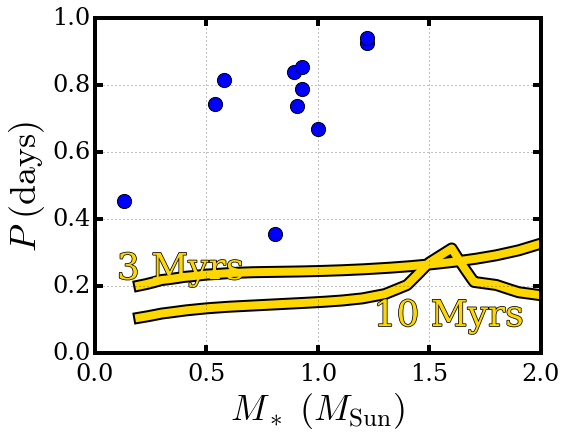

In [36]:
import matplotlib.patheffects as PathEffects

fig = pl.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.scatter(data['MSTAR'], data['PER'], s=200)

#mode from Salyk's sample
truncation_radius = 0.05 #AU
stellar_masses = np.arange(min_Ms, 2., 0.01)
stopping_periods = (truncation_radius**3/(4*np.pi*np.pi*stellar_masses))**(1./3)*365.25/2.
# ax.plot(stellar_masses, stopping_periods, lw=8, color='red', zorder=-1)
# ax.annotate('$P(R_{\\rm in})/2$', xy=(1.6, 2.4), xytext=(1.35, 3.8), color='red',
#            arrowprops=dict(facecolor='red', shrink=0.025, width=10, frac=0.25, headwidth=30), fontsize=36, zorder=-1)

ax.set_ylim([0., 1.])
ax.set_xlim([0., 2.])
ax.set_xlabel('$M_*\ (M_{\\rm Sun})$', fontsize=36)
ax.set_ylabel('$P\ {\\rm (days)}$', fontsize=36)

#fig.savefig('P-vs-Mstar_no-Pstar.png', dpi=500, bbox_inches='tight')

stellar_radii = stellar_radius(stellar_masses, desired_age=3e6)*Rsun_to_AU
stellar_periods = Kepler_period(stellar_radii, stellar_masses)*365.25
ax.plot(stellar_masses, stellar_periods, lw=12, color='black', zorder=-1)
ax.plot(stellar_masses, stellar_periods, lw=8, color='gold', zorder=0)

stellar_radii = stellar_radius(stellar_masses, desired_age=10e6)*Rsun_to_AU
stellar_periods = Kepler_period(stellar_radii, stellar_masses)*365.25
ax.plot(stellar_masses, stellar_periods, lw=12, color='black', zorder=-1)
ax.plot(stellar_masses, stellar_periods, lw=8, color='gold', zorder=0)

ax.text(0.1, 0.22, '3 Myrs', color='gold', fontsize=36, zorder=-1, 
        path_effects=[PathEffects.withStroke(linewidth=1.5, foreground="black")])

ax.text(1.25, 0.08, '10 Myrs', color='gold', fontsize=36, zorder=-1, 
        path_effects=[PathEffects.withStroke(linewidth=1.5, foreground="black")])


# ax.annotate('$P(R_*)_{\\rm 3\ Myrs}$', xy=(1.5, 1.5), xytext=(1, 0.2), color='gold',
#            arrowprops=dict(facecolor='gold', shrink=0.025, width=10, frac=0.25, headwidth=30), fontsize=36, zorder=-1, 
#            path_effects=[PathEffects.withStroke(linewidth=1.5, foreground="black")])

#fig.savefig('P-vs-Mstar.png', dpi=500, bbox_inches='tight')

#Adding GJ 1214 b
GJ1214b_period = 1.58 #http://exoplanets.org/detail/GJ_1214_b
GJ1214b_Ms = 0.157 
#ax.scatter(GJ1214b_Ms, GJ1214b_period, s=500, color='red')

ax.tick_params(axis='both', which='major', labelsize=24)

(0, 0.1)

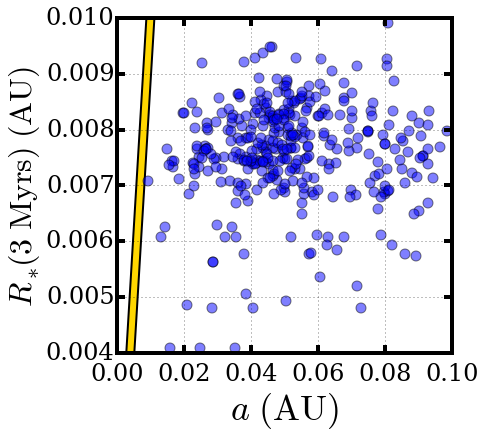

In [149]:
fig = pl.figure(figsize=(6,6))
ax = fig.add_subplot(111)

valid_Ms = data['MSTAR'][~data['MSTAR'].mask]
valid_a = data['A'][~data['MSTAR'].mask]

ind = valid_Ms > min_Ms

stellar_radii = stellar_radius(valid_Ms[ind])*Rsun_to_AU
ax.scatter(valid_a[ind], stellar_radii, s=100, alpha=0.5)
x = np.arange(0, 0.1, 0.01)
ax.plot(x, x, lw=6, color='gold', zorder=0)
ax.plot(x, x, lw=10, color='black', zorder=-1)

ax.set_xlabel('$a\ ({\\rm AU})$', fontsize=36)
ax.set_ylabel('$R_*(3\ {\\rm Myrs})\ ({\\rm AU})$', fontsize=32)

ax.set_ylim([0.004, 0.01])
ax.set_xlim([0, 0.1])

In [113]:
data_file_name = "LopezFortney2014_Table7.txt"
LopezFortney_Table7 = ascii.read(data_file_name, delimiter=',')
#print(LopezFortney_Table7)
fenv = LopezFortney_Table7['H/He Envelope Fraction']
LopezFortney_Table7['core mass'] = LopezFortney_Table7['Mass (M_oplus)']*(1. - fenv/100.)

SuperEarths = join(LopezFortney_Table7, data)
ind = SuperEarths['NAME'] == 'GJ1214b'
print((SuperEarths[ind])['NAME'], (SuperEarths[ind])['PER'], 
      (SuperEarths[ind])['H/He Envelope Fraction']/100., (SuperEarths[ind])['core mass'])

(<MaskedColumn name='NAME' dtype='string96' length=1>
GJ1214b, <MaskedColumn name='PER' dtype='float64' length=1>
1.58040482, <MaskedColumn name='H/He Envelope Fraction' dtype='float64' length=1>
0.0383, <MaskedColumn name='core mass' dtype='float64' length=1>
6.212582)
